<h3> References <br> </h3>
<h4>
https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/ <br>
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/gan.ipynb#scrollTo=5d5IMJTr_tnN
<br>
https://github.com/elena-ecn/optuna-optimization-for-PyTorch-CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import ToTensor

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")

# Question 1

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/DLOps_A4/GAN_data.csv')
len(df.columns)

1025

In [ ]:
df.columns

Index(['pixel_0000', 'pixel_0001', 'pixel_0002', 'pixel_0003', 'pixel_0004',
       'pixel_0005', 'pixel_0006', 'pixel_0007', 'pixel_0008', 'pixel_0009',
       ...
       'pixel_1015', 'pixel_1016', 'pixel_1017', 'pixel_1018', 'pixel_1019',
       'pixel_1020', 'pixel_1021', 'pixel_1022', 'pixel_1023', 'character'],
      dtype='object', length=1025)

In [ ]:
df['character'].unique()

array(['character_01_ka', 'character_02_kha', 'character_03_ga',
       'character_04_gha', 'character_05_kna', 'character_06_cha',
       'character_07_chha', 'character_08_ja', 'character_09_jha',
       'character_10_yna', 'character_11_taamatar', 'character_12_thaa',
       'character_13_daa', 'character_14_dhaa', 'character_15_adna',
       'character_16_tabala', 'character_17_tha', 'character_18_da',
       'character_19_dha', 'character_20_na', 'character_21_pa',
       'character_22_pha', 'character_23_ba', 'character_24_bha',
       'character_25_ma', 'character_26_yaw', 'character_27_ra',
       'character_28_la', 'character_29_waw', 'character_30_motosaw',
       'character_31_petchiryakha', 'character_32_patalosaw',
       'character_33_ha', 'character_34_chhya', 'character_35_tra',
       'character_36_gya', 'digit_0', 'digit_1', 'digit_2', 'digit_3',
       'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9'],
      dtype=object)

In [ ]:
len(df['character'].unique())

46

In [ ]:
df['character'].value_counts()

character_01_ka              2000
character_35_tra             2000
character_26_yaw             2000
character_27_ra              2000
character_28_la              2000
character_29_waw             2000
character_30_motosaw         2000
character_31_petchiryakha    2000
character_32_patalosaw       2000
character_33_ha              2000
character_34_chhya           2000
character_36_gya             2000
character_02_kha             2000
digit_0                      2000
digit_1                      2000
digit_2                      2000
digit_3                      2000
digit_4                      2000
digit_5                      2000
digit_6                      2000
digit_7                      2000
digit_8                      2000
character_25_ma              2000
character_24_bha             2000
character_23_ba              2000
character_22_pha             2000
character_03_ga              2000
character_04_gha             2000
character_05_kna             2000
character_06_c

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

# Step 1: Load the CSV file
data = pd.read_csv('/content/drive/MyDrive/Deep Learning/DLOps_A4/GAN_data.csv')
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels

In [ ]:
print(len(X), len(X[0]))

92000 1024


character_01_ka


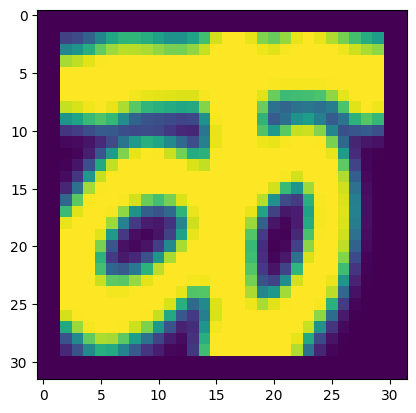

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

sample_image = X[0].reshape(32, 32)
resized_image = np.array(Image.fromarray(np.uint8(sample_image)).resize((32, 32)))
plt.imshow(resized_image)
print(y[0])

character_06_cha


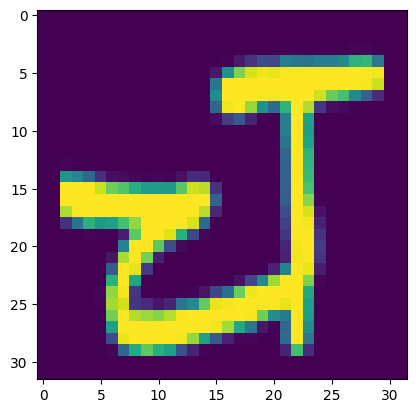

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

sample_image = X[11113].reshape(32, 32)
resized_image = np.array(Image.fromarray(np.uint8(sample_image)).resize((32, 32)))
plt.imshow(resized_image)
print(y[11113])

In [ ]:
# Step 2: Label encode the class labels
le = LabelEncoder()
y = le.fit_transform(y)

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train[0])

1024

In [ ]:
# Step 4: Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Load image
        img = self.X[idx].reshape(32, 32)  # Reshape the image to (32, 32)
        img = np.uint8(img * 255)  # Scale the pixel values to 0-255 and convert to uint8 type
        img = Image.fromarray(img)  # Convert the numpy array to PIL Image
        
        # Apply transformations (if any)
        if self.transform is not None:
            img = self.transform(img)
        
        # Get label
        label = self.y[idx]
        
        return img, label

In [ ]:
batch_size = 64
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transforms)
test_dataset = CustomDataset(X_test, y_test, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
sample_train_image, _ = train_dataset[0]
print(sample_train_image.shape)  # Output: (channels, height, width)

sample_test_image, _ = test_dataset[0]
print(sample_test_image.shape)  # Output: (channels, height, width)


torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


In [ ]:
import torch.nn as nn

# Define the binary cross entropy loss function
binary_cross_entropy = nn.BCELoss()
celoss = nn.CrossEntropyLoss()
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    # gen_loss = celoss(label, fake_output)
    return gen_loss
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_classes = 46, embedding_dim = 64, latent_dim = 64):
        super(Generator, self).__init__()
         
        # class label as input, embedding layer of 100 output neurons, linear layer with 16 output neurons
        self.label_conditioned_generator = \
        nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))
         
        # fed noise or latent vector of 100 input neurons, output 4*4*512 neurons 
        self.latent = \
        nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))
            
        # each block upsamples the input twice 
        # 513*4*4 --> 512*8*8 --> 64*16*16 --> 1*32*32
        self.model = \
        nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*1, 1, 4, 2, 1,bias=False),
                      nn.Tanh()
                      )
        
    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_classes = 46, embedding_dim = 64):
        super(Discriminator, self).__init__()
         
     
        self.label_condition_disc = \
        nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 1*32*32))
        
        # conncatened real and fake input image, hence input dims = 2*32*32
        # outputs if an image is real or fake (0, 1)
        # 2*32*32 --> 64*15*15 --> 512*6*6
        self.model = \
        nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(18432, 1),
                      nn.Sigmoid()
                     )
 
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 1, 32, 32)
        concat = torch.cat((img, label_output), dim=1)  # 1*32*32 concat with 1*32*32 --> 2*32*32
        #print(concat.size())
        output = self.model(concat)
        return output

In [ ]:
n_classes = 46
embedding_dim = 64
latent_dim = 64

generator = Generator(n_classes, embedding_dim, latent_dim).to(device)
discriminator = Discriminator(n_classes, embedding_dim).to(device)

In [ ]:
import torch
from tqdm import tqdm

class GANTrainer:
    def __init__(self, discriminator, generator, device="cpu", latent_dim=64):
        self.discriminator = discriminator.to(device)
        self.generator = generator.to(device)
        self.device = device
        self.latent_dim = latent_dim
    
    def train_epochs(self, train_loader, epochs, D_optimizer, G_optimizer):
        disc_loss = []
        gen_loss = []

        for epoch in range(epochs):
            epoch_disc_loss = 0
            epoch_gen_loss = 0
            self.discriminator.train()
            self.generator.train()

            for real_inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                real_inputs, labels = real_inputs.to(self.device), labels.to(self.device)
                labels = labels.unsqueeze(1).long()

                real_target = torch.ones(real_inputs.size(0), 1).to(self.device)
                fake_target = torch.zeros(real_inputs.size(0), 1).to(self.device)

                # Train discriminator every even epoch
                self.discriminator.zero_grad()
                D_real_output = self.discriminator((real_inputs, labels))
                D_real_loss = self.discriminator_loss(D_real_output, real_target)

                noise_vector = (torch.randn(real_inputs.size(0), self.latent_dim)*0.1).to(self.device)
                generated_image = self.generator((noise_vector, labels))
                D_fake_output = self.discriminator((generated_image.detach(), labels))
                D_fake_loss = self.discriminator_loss(D_fake_output, fake_target)

                D_loss = (D_real_loss + D_fake_loss) / 2
                #if epoch % 2 == 0:
                D_loss.backward()
                D_optimizer.step()
                epoch_disc_loss += D_loss.item()

                # Train generator every epoch
                self.generator.zero_grad()
                G_output = self.discriminator((generated_image, labels))
                G_loss = self.generator_loss(G_output, real_target)

                G_loss.backward()
                G_optimizer.step()
                epoch_gen_loss += G_loss.item()

            # Update losses
            disc_loss.append(epoch_disc_loss / len(train_loader))
            gen_loss.append(epoch_gen_loss / len(train_loader))
            print(f"Epoch {epoch+1}/{epochs} - Discriminator loss: {disc_loss[-1]:.4f} - Generator loss: {gen_loss[-1]:.4f}")

        return disc_loss, gen_loss

trainer = GANTrainer(discriminator, generator, device, latent_dim)

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
# for generator loss it is calculated between real target and generated image's output
# for discrimator loss it is calculated between discriminator outputs and real/fake targets
G_optimizer = torch.optim.Adam(generator.parameters(), lr = 3e-4, weight_decay = 5e-4)
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 3e-4, weight_decay = 5e-4)

epochs = 30
disc_loss, gen_loss = trainer.train_epochs(train_loader, epochs, D_optimizer, G_optimizer)

Epoch 1/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 1/30 - Discriminator loss: 0.1427 - Generator loss: 4.4348


Epoch 2/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 2/30 - Discriminator loss: 0.0663 - Generator loss: 5.6347


Epoch 3/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 3/30 - Discriminator loss: 0.0257 - Generator loss: 5.8138


Epoch 4/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 4/30 - Discriminator loss: 0.0164 - Generator loss: 6.3222


Epoch 5/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 5/30 - Discriminator loss: 0.0113 - Generator loss: 6.1382


Epoch 6/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 6/30 - Discriminator loss: 0.0117 - Generator loss: 6.4326


Epoch 7/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 7/30 - Discriminator loss: 0.0095 - Generator loss: 6.5607


Epoch 8/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 8/30 - Discriminator loss: 0.0047 - Generator loss: 6.7786


Epoch 9/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 9/30 - Discriminator loss: 0.0048 - Generator loss: 6.9990


Epoch 10/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 10/30 - Discriminator loss: 0.0043 - Generator loss: 7.2120


Epoch 11/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 11/30 - Discriminator loss: 0.0042 - Generator loss: 7.2117


Epoch 12/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 12/30 - Discriminator loss: 0.0030 - Generator loss: 7.3120


Epoch 13/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 13/30 - Discriminator loss: 0.0054 - Generator loss: 7.3951


Epoch 14/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 14/30 - Discriminator loss: 0.0125 - Generator loss: 6.8597


Epoch 15/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 15/30 - Discriminator loss: 0.0039 - Generator loss: 7.2925


Epoch 16/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 16/30 - Discriminator loss: 0.0055 - Generator loss: 7.0916


Epoch 17/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 17/30 - Discriminator loss: 0.0039 - Generator loss: 7.0458


Epoch 18/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 18/30 - Discriminator loss: 0.0023 - Generator loss: 7.0805


Epoch 19/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 19/30 - Discriminator loss: 0.0030 - Generator loss: 7.1383


Epoch 20/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 20/30 - Discriminator loss: 0.0029 - Generator loss: 7.3233


Epoch 21/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 21/30 - Discriminator loss: 0.0016 - Generator loss: 7.3106


Epoch 22/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 22/30 - Discriminator loss: 0.0040 - Generator loss: 7.2259


Epoch 23/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 23/30 - Discriminator loss: 0.0023 - Generator loss: 7.2005


Epoch 24/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 24/30 - Discriminator loss: 0.0021 - Generator loss: 7.2462


Epoch 25/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 25/30 - Discriminator loss: 0.0019 - Generator loss: 7.3677


Epoch 26/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 26/30 - Discriminator loss: 0.0022 - Generator loss: 7.3668


Epoch 27/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 27/30 - Discriminator loss: 0.0090 - Generator loss: 7.5462


Epoch 28/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 28/30 - Discriminator loss: 0.0043 - Generator loss: 7.1337


Epoch 29/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 29/30 - Discriminator loss: 0.0027 - Generator loss: 7.3228


Epoch 30/30:   0%|          | 0/1150 [00:00<?, ?it/s]

Epoch 30/30 - Discriminator loss: 0.0025 - Generator loss: 7.1825


In [ ]:
torch.save(generator.state_dict(), '/content/drive/MyDrive/Deep Learning/DLOps_A4/generator_weights_4.pth')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Deep Learning/DLOps_A4/discriminator_weights_4.pth')

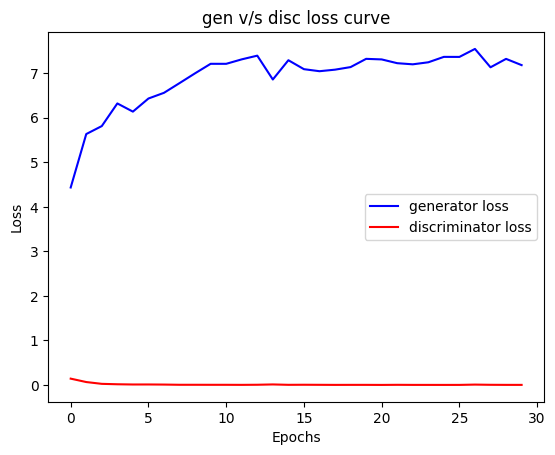

In [ ]:
plt.plot(gen_loss, 'b-', label='generator loss')
plt.plot(disc_loss, 'r-', label='discriminator loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('gen v/s disc loss curve')
plt.show()

### load model

In [ ]:
n_classes = 46
embedding_dim = 64
latent_dim = 64
generator = Generator(n_classes, embedding_dim, latent_dim).to(device)
discriminator = Discriminator(n_classes, embedding_dim).to(device)

generator.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/DLOps_A4/generator_weights_4.pth'))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/DLOps_A4/discriminator_weights_4.pth'))


<All keys matched successfully>

In [ ]:
class ImageGenerator:
    def __init__(self, model):
        self.model = model.eval()
        
    def generate_images(self, noise_vector, n_classes):
        self.model.eval()
        output = None
        for label in range(n_classes):
            labels = torch.ones(noise_vector.shape[0], 1) * label
            labels = labels.long()
            labels = labels.to(device)
            with torch.no_grad():
                predictions = self.model((noise_vector, labels))
            pred = ((predictions[0][0] + 1)*127.5).cpu().detach()
            plt.imshow(pred.permute(1,2,0))
            plt.show()

ig = ImageGenerator(generator)

tensor([[[-0.9446, -0.9838, -0.9484,  ..., -1.0000, -0.9967, -0.9992],
         [-0.9938, -0.9996, -0.9979,  ..., -1.0000, -0.9999, -0.9999],
         [-0.9958, -0.9968, -0.4378,  ..., -0.9999, -1.0000, -0.9926],
         ...,
         [-1.0000, -1.0000, -0.9837,  ..., -0.9999, -0.9794, -0.9994],
         [-0.9984, -0.9999, -0.9914,  ..., -0.9826, -0.9989, -0.9972],
         [-0.9985, -0.9999, -0.9907,  ..., -0.9994, -0.9947, -0.9946]]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[[-0.8897, -0.9697, -0.9568,  ..., -0.9999, -0.9787, -0.9886],
         [-0.9837, -0.9994, -0.9958,  ..., -1.0000, -0.9944, -0.9986],
         [-0.9929, -0.9984, -0.7491,  ..., -0.9656, -0.9988, -0.9722],
         ...,
         [-1.0000, -1.0000, -0.9969,  ..., -0.9954, -0.9437, -0.9939],
         [-0.9989, -1.0000, -0.9943,  ..., -0.9793, -0.9975, -0.9913],
         [-0.9984, -0.9999, -0.9913,  ..., -0.9992, -0.9892, -0.9881]]],
       device='cuda:0', grad_fn=<SelectBackward0>)


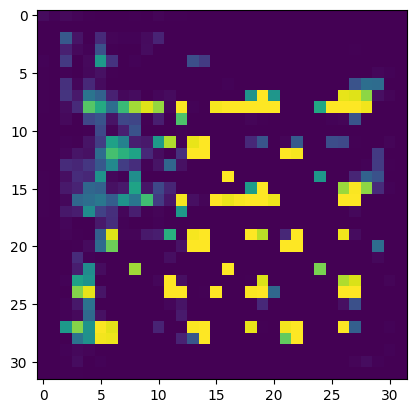

tensor([[[-0.9445, -0.9838, -0.9481,  ..., -1.0000, -0.9967, -0.9992],
         [-0.9937, -0.9996, -0.9979,  ..., -1.0000, -0.9999, -0.9999],
         [-0.9958, -0.9968, -0.4396,  ..., -0.9999, -1.0000, -0.9926],
         ...,
         [-1.0000, -1.0000, -0.9837,  ..., -0.9999, -0.9795, -0.9994],
         [-0.9984, -0.9999, -0.9914,  ..., -0.9827, -0.9989, -0.9972],
         [-0.9985, -0.9999, -0.9908,  ..., -0.9994, -0.9948, -0.9946]]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[[-0.8895, -0.9697, -0.9566,  ..., -0.9999, -0.9787, -0.9886],
         [-0.9836, -0.9994, -0.9957,  ..., -1.0000, -0.9944, -0.9986],
         [-0.9929, -0.9984, -0.7496,  ..., -0.9656, -0.9988, -0.9722],
         ...,
         [-1.0000, -1.0000, -0.9969,  ..., -0.9955, -0.9439, -0.9939],
         [-0.9989, -1.0000, -0.9943,  ..., -0.9794, -0.9975, -0.9913],
         [-0.9984, -0.9999, -0.9913,  ..., -0.9992, -0.9892, -0.9882]]],
       device='cuda:0', grad_fn=<SelectBackward0>)


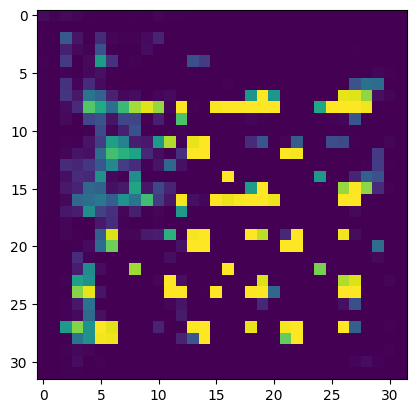

tensor([[[-0.9446, -0.9838, -0.9483,  ..., -1.0000, -0.9967, -0.9992],
         [-0.9938, -0.9996, -0.9979,  ..., -1.0000, -0.9999, -0.9999],
         [-0.9958, -0.9968, -0.4384,  ..., -0.9999, -1.0000, -0.9926],
         ...,
         [-1.0000, -1.0000, -0.9837,  ..., -0.9999, -0.9795, -0.9994],
         [-0.9984, -0.9999, -0.9914,  ..., -0.9826, -0.9989, -0.9972],
         [-0.9985, -0.9999, -0.9908,  ..., -0.9994, -0.9948, -0.9946]]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[[-0.8896, -0.9697, -0.9568,  ..., -0.9999, -0.9787, -0.9886],
         [-0.9837, -0.9994, -0.9958,  ..., -1.0000, -0.9944, -0.9986],
         [-0.9929, -0.9984, -0.7492,  ..., -0.9656, -0.9988, -0.9722],
         ...,
         [-1.0000, -1.0000, -0.9969,  ..., -0.9955, -0.9437, -0.9939],
         [-0.9989, -1.0000, -0.9943,  ..., -0.9794, -0.9975, -0.9913],
         [-0.9984, -0.9999, -0.9913,  ..., -0.9992, -0.9892, -0.9881]]],
       device='cuda:0', grad_fn=<SelectBackward0>)


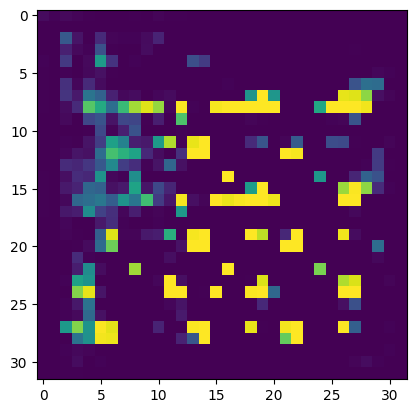

In [ ]:
images_to_generate = 10
noise = torch.randn(images_to_generate, latent_dim).to(device)
ig.generate_images(noise, n_classes)

In [ ]:
num_classes = 46
num_samples_per_class = 50
latent_dim = 64

generated_samples = []

# Generate 50 samples for each class
for class_idx in range(num_classes):
    for i in range(num_samples_per_class):
        # generate random latent vector
        latent_vector = torch.randn(1, latent_dim, device=device)
        
        # generate sample
        label = torch.tensor([class_idx], device=device)
        sample = generator((latent_vector, label)).detach().cpu().numpy().squeeze()
        
        generated_samples.append(sample)

In [ ]:
len(generated_samples)

2300

In [ ]:
import pandas as pd

num_classes = 46
num_samples_per_class = 50
latent_dim = 64

generated_samples = []

# Generate 50 samples for each class
for class_idx in range(num_classes):
    for i in range(num_samples_per_class):
        # generate random latent vector
        latent_vector = torch.randn(1, latent_dim, device=device)
        
        # generate sample
        label = torch.tensor([class_idx], device=device)
        sample = generator((latent_vector, label)).detach().cpu().numpy().squeeze()
        
        generated_samples.append(sample)

# Convert the list of samples into a NumPy array
generated_samples = np.array(generated_samples)

# Reshape the samples to have a single row for each image
flattened_samples = generated_samples.reshape(num_classes*num_samples_per_class, -1)

# Create a data frame with the flattened samples
df = pd.DataFrame(flattened_samples)

# Add a column for the labels
labels = np.repeat(range(num_classes), num_samples_per_class)
df['label'] = labels

# Print the data frame
print(df.head())


          0         1         2         3         4         5         6  \
0 -0.995078 -0.998657 -0.993308 -0.997326 -0.995462 -0.999999 -0.999782   
1 -0.997747 -0.999687 -0.998250 -0.997514 -0.995922 -1.000000 -0.999991   
2 -0.975141 -0.992393 -0.970528 -0.988191 -0.990594 -0.999969 -0.998281   
3 -0.941502 -0.983429 -0.977765 -0.986128 -0.991590 -0.999659 -0.990084   
4 -0.916018 -0.971498 -0.923518 -0.944990 -0.969678 -0.998815 -0.987045   

          7         8         9  ...      1015      1016      1017      1018  \
0 -1.000000 -0.994198 -0.999998  ... -0.999978 -0.999087 -0.999860 -0.989910   
1 -1.000000 -0.995818 -1.000000  ... -0.999978 -0.999533 -0.999970 -0.994863   
2 -0.999980 -0.989897 -0.999919  ... -0.999992 -0.998981 -0.999809 -0.989059   
3 -0.998625 -0.985334 -0.997564  ... -0.999963 -0.999063 -0.999866 -0.991473   
4 -0.998873 -0.977485 -0.997607  ... -0.999990 -0.998757 -0.999872 -0.989588   

       1019      1020      1021      1022      1023  label  
0 -0.99

In [ ]:
X_test = df.iloc[:, :-1].values  # Features
y_test = df.iloc[:, -1].values  # Labels

In [ ]:
# Step 5: Define PyTorch data loaders
batch_size = 64

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),  # convert to 3-channel images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert to 3-channel images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transforms)
test_dataset = CustomDataset(X_test, y_test, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [ ]:
# define model
resnet = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 46)

# define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=2e-3, weight_decay = 5e-4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.1MB/s]


In [ ]:
resnet = resnet.to(device)

In [ ]:
def train(model, device, train_loader, optimizer, epoch, reg_strength=0.001):
    model.train()
    train_loss = 0
    train_correct_top1 = 0
    train_correct_top5 = 0
    num_batches = len(train_loader)
    with tqdm(total=num_batches, desc=f'Training Epoch {epoch}', unit='batch') as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            # print(data.shape)
            output = model(data)
            loss = F.cross_entropy(output, target)

            # L2 regularization
            reg_loss = sum(param.norm(2) ** 2 for param in model.parameters())
            loss += reg_strength * reg_loss

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate top-1 and top-5 accuracy
            _, predicted = torch.topk(output, k=5, dim=1)
            train_correct_top1 += torch.sum(predicted[:, 0] == target)
            train_correct_top5 += torch.sum(predicted == target.unsqueeze(1))

            # Update progress bar
            pbar.set_postfix({'loss': train_loss / (batch_idx + 1)})
            pbar.update()

    train_loss /= len(train_loader.dataset)
    train_acc_top1 = train_correct_top1.double() / len(train_loader.dataset)
    train_acc_top5 = train_correct_top5.double() / len(train_loader.dataset)
    return train_loss, train_acc_top1, train_acc_top5
    
def test(model, device, test_loader, reg_strength=0.001):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_correct_top5 = 0
    num_batches = len(test_loader)
    with tqdm(total=num_batches, desc='Testing', unit='batch') as pbar:
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.cross_entropy(output, target, reduction='sum')

                # L2 regularization
                reg_loss = sum(param.norm(2) ** 2 for param in model.parameters())
                loss += reg_strength * reg_loss

                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

                # Top-5 accuracy
                _, top5_predicted = torch.topk(output.data, 5, dim=1)
                for i in range(len(target)):
                    if target[i] in top5_predicted[i]:
                        test_correct_top5 += 1

                # Update progress bar
                pbar.set_postfix({'loss': test_loss / (batch_idx + 1)})
                pbar.update()

    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / test_total
    test_acc_top5 = test_correct_top5 / test_total
    return test_loss, test_acc, test_acc_top5


In [ ]:
# He weight initialization
for name, param in resnet.named_parameters():
    if 'weight' in name:
        if len(param.shape) < 2:
          continue
        nn.init.kaiming_normal_(param)


In [ ]:
test_losses = []
test_accuracies_top1 = []
test_accuracies_top5 = []
train_losses = []
train_accuracies_top1 = []
train_accuracied_top5 = []
num_epochs = 15
# Train and test the model
for epoch in range(num_epochs):
    train_loss, train_acc_top1, train_acc_top5 = train(resnet, device, train_loader, optimizer, epoch)
    test_loss, test_acc_top1, test_acc_top5 = test(resnet, device, test_loader)
    train_losses.append(train_loss)
    train_accuracies_top1.append(train_acc_top1)
    train_accuracied_top5.append(train_acc_top5)
    test_losses.append(test_loss)
    test_accuracies_top1.append(test_acc_top1)
    test_accuracies_top5.append(test_acc_top5)
    print()
    print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
    print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
    print()

train_losses = torch.tensor(train_losses)
train_accuracies_top1 = torch.tensor(train_accuracies_top1)
train_accuracied_top5 = torch.tensor(train_accuracied_top5)
test_losses = torch.tensor(test_losses)
test_accuracies_top1 = torch.tensor(test_accuracies_top1)
test_accuracies_top5 = torch.tensor(test_accuracies_top5)

train_losses = train_losses.cpu().numpy()
train_accuracies_top1 = train_accuracies_top1.cpu().numpy()
train_accuracied_top5 = train_accuracied_top5.cpu().numpy()
test_losses = test_losses.cpu().numpy()
test_accuracies_top1 = test_accuracies_top1.cpu().numpy()
test_accuracies_top5 = test_accuracies_top5.cpu().numpy()


Training Epoch 0:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  1 Train Loss:  0.08562802945952053 Train Acc top 1:  0.4154483695652174 Test Loss:  5.605498060143512 Test Acc top 1:  0.02043478260869565
Train Acc top 5:  0.6871195652173914 Test Acc top 5:  0.10739130434782608



Training Epoch 1:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  2 Train Loss:  0.02430873003990754 Train Acc top 1:  0.8185597826086957 Test Loss:  6.685581320057745 Test Acc top 1:  0.023043478260869565
Train Acc top 5:  0.9761005434782609 Test Acc top 5:  0.10869565217391304



Training Epoch 2:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  3 Train Loss:  0.01867250526404899 Train Acc top 1:  0.8598777173913044 Test Loss:  5.777871100384256 Test Acc top 1:  0.022608695652173914
Train Acc top 5:  0.9835733695652175 Test Acc top 5:  0.1117391304347826



Training Epoch 3:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  4 Train Loss:  0.016361140989415025 Train Acc top 1:  0.8808831521739131 Test Loss:  7.131308480967646 Test Acc top 1:  0.021304347826086957
Train Acc top 5:  0.9862771739130435 Test Acc top 5:  0.10782608695652174



Training Epoch 4:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  5 Train Loss:  0.014638036795608376 Train Acc top 1:  0.8932744565217392 Test Loss:  7.295217318327531 Test Acc top 1:  0.023478260869565216
Train Acc top 5:  0.9884103260869566 Test Acc top 5:  0.10521739130434783



Training Epoch 5:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  6 Train Loss:  0.013603295948680328 Train Acc top 1:  0.8999184782608696 Test Loss:  7.587859264871349 Test Acc top 1:  0.02
Train Acc top 5:  0.9898233695652174 Test Acc top 5:  0.1091304347826087



Training Epoch 6:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  7 Train Loss:  0.012984035580378512 Train Acc top 1:  0.9037907608695652 Test Loss:  7.058696043595024 Test Acc top 1:  0.02043478260869565
Train Acc top 5:  0.9908016304347826 Test Acc top 5:  0.11347826086956522



Training Epoch 7:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  8 Train Loss:  0.01247500410789381 Train Acc top 1:  0.9069701086956522 Test Loss:  7.868236044178838 Test Acc top 1:  0.02391304347826087
Train Acc top 5:  0.9907744565217391 Test Acc top 5:  0.11347826086956522



Training Epoch 8:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  9 Train Loss:  0.012146308166987222 Train Acc top 1:  0.9087228260869565 Test Loss:  6.857432158096977 Test Acc top 1:  0.02391304347826087
Train Acc top 5:  0.9914945652173913 Test Acc top 5:  0.1108695652173913



Training Epoch 9:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  10 Train Loss:  0.011871003050195134 Train Acc top 1:  0.9122010869565218 Test Loss:  6.963844432001529 Test Acc top 1:  0.015217391304347827
Train Acc top 5:  0.9915353260869566 Test Acc top 5:  0.10782608695652174



Training Epoch 10:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  11 Train Loss:  0.01171559139519282 Train Acc top 1:  0.912241847826087 Test Loss:  7.193378415315047 Test Acc top 1:  0.02391304347826087
Train Acc top 5:  0.9921467391304348 Test Acc top 5:  0.10782608695652174



Training Epoch 11:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  12 Train Loss:  0.011549517107398613 Train Acc top 1:  0.9146875 Test Loss:  7.447001183551291 Test Acc top 1:  0.02391304347826087
Train Acc top 5:  0.9919972826086957 Test Acc top 5:  0.10869565217391304



Training Epoch 12:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  13 Train Loss:  0.011466608824127394 Train Acc top 1:  0.9138722826086957 Test Loss:  7.006751954451851 Test Acc top 1:  0.021304347826086957
Train Acc top 5:  0.9926222826086957 Test Acc top 5:  0.10608695652173913



Training Epoch 13:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  14 Train Loss:  0.011466781249998705 Train Acc top 1:  0.9150135869565218 Test Loss:  7.775950755243716 Test Acc top 1:  0.01956521739130435
Train Acc top 5:  0.9918070652173914 Test Acc top 5:  0.10695652173913044



Training Epoch 14:   0%|          | 0/1150 [00:00<?, ?batch/s]

Testing:   0%|          | 0/36 [00:00<?, ?batch/s]


Epoch:  15 Train Loss:  0.011305790386446144 Train Acc top 1:  0.916983695652174 Test Loss:  7.006416990860648 Test Acc top 1:  0.023478260869565216
Train Acc top 5:  0.9926766304347826 Test Acc top 5:  0.10695652173913044



In [ ]:
torch.save(resnet.state_dict(), '/content/drive/MyDrive/Deep Learning/DLOps_A4/resnet_dlops_a4_4.pth')

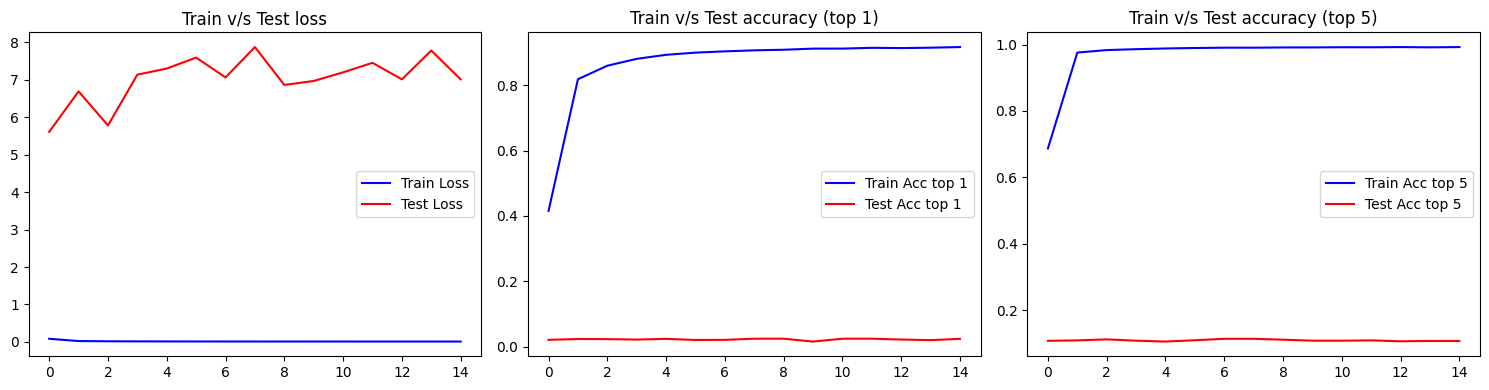

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot train and test loss
axs[0].plot(train_losses,'b-', label='Train Loss')
axs[0].plot(test_losses,'r-', label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

# Plot top 1 train and test accuracy
axs[1].plot(train_accuracies_top1,'b-', label='Train Acc top 1')
axs[1].plot(test_accuracies_top1,'r-', label='Test Acc top 1')
axs[1].set_title('Train v/s Test accuracy (top 1)')
axs[1].legend()

# Plot top 5 train and test accuracy
axs[2].plot(train_accuracied_top5,'b-', label='Train Acc top 5')
axs[2].plot(test_accuracies_top5,'r-', label='Test Acc top 5')
axs[2].set_title('Train v/s Test accuracy (top 5)')
axs[2].legend()

plt.tight_layout()
plt.show()


### load model

In [ ]:
# resnet.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning/DLOps_A4/resnet_dlops_a4.pth'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

resnet.eval()
true_labels = []
predicted_labels = []
num_batches = len(test_loader)
with tqdm(total=num_batches, desc='Testing', unit='batch') as pbar:
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = resnet(data)
            loss = F.cross_entropy(output, target, reduction='sum')
            predicted = torch.argmax(output.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
            # Update progress bar
            pbar.update()


Testing:   0%|          | 0/36 [00:00<?, ?batch/s]

In [ ]:
# Create a list of unique labels in the dataset
labels = []
for data, target in test_loader:
    labels += target.numpy().tolist()
classes = list(set(labels))


In [ ]:
# Calculate F1 score for each class
f1_scores = f1_score(true_labels, predicted_labels, average=None, labels=classes)

# Print F1 score for each class
for i, f1_score in enumerate(f1_scores):
    print(f'F1 Score for {classes[i]}: {f1_score:.4f}')


F1 Score for 0: 0.0656
F1 Score for 1: 0.0000
F1 Score for 2: 0.0000
F1 Score for 3: 0.0000
F1 Score for 4: 0.0000
F1 Score for 5: 0.0000
F1 Score for 6: 0.0000
F1 Score for 7: 0.0000
F1 Score for 8: 0.0435
F1 Score for 9: 0.0000
F1 Score for 10: 0.0000
F1 Score for 11: 0.0000
F1 Score for 12: 0.0000
F1 Score for 13: 0.0000
F1 Score for 14: 0.0000
F1 Score for 15: 0.0000
F1 Score for 16: 0.0000
F1 Score for 17: 0.0000
F1 Score for 18: 0.0000
F1 Score for 19: 0.0000
F1 Score for 20: 0.0000
F1 Score for 21: 0.0323
F1 Score for 22: 0.0000
F1 Score for 23: 0.0000
F1 Score for 24: 0.0000
F1 Score for 25: 0.0000
F1 Score for 26: 0.0000
F1 Score for 27: 0.0000
F1 Score for 28: 0.0000
F1 Score for 29: 0.0000
F1 Score for 30: 0.0000
F1 Score for 31: 0.0377
F1 Score for 32: 0.0000
F1 Score for 33: 0.0000
F1 Score for 34: 0.0000
F1 Score for 35: 0.0000
F1 Score for 36: 0.0000
F1 Score for 37: 0.0000
F1 Score for 38: 0.0000
F1 Score for 39: 0.0000
F1 Score for 40: 0.0000
F1 Score for 41: 0.0000
F1

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(true_labels, predicted_labels)
np.set_printoptions(threshold=np.inf)
print("Confusion Matrix:\n", confusion_mat)


Confusion Matrix:
 [[ 4  0  0  0  0  0  0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 47  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0
   0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 47  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 45  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 49  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

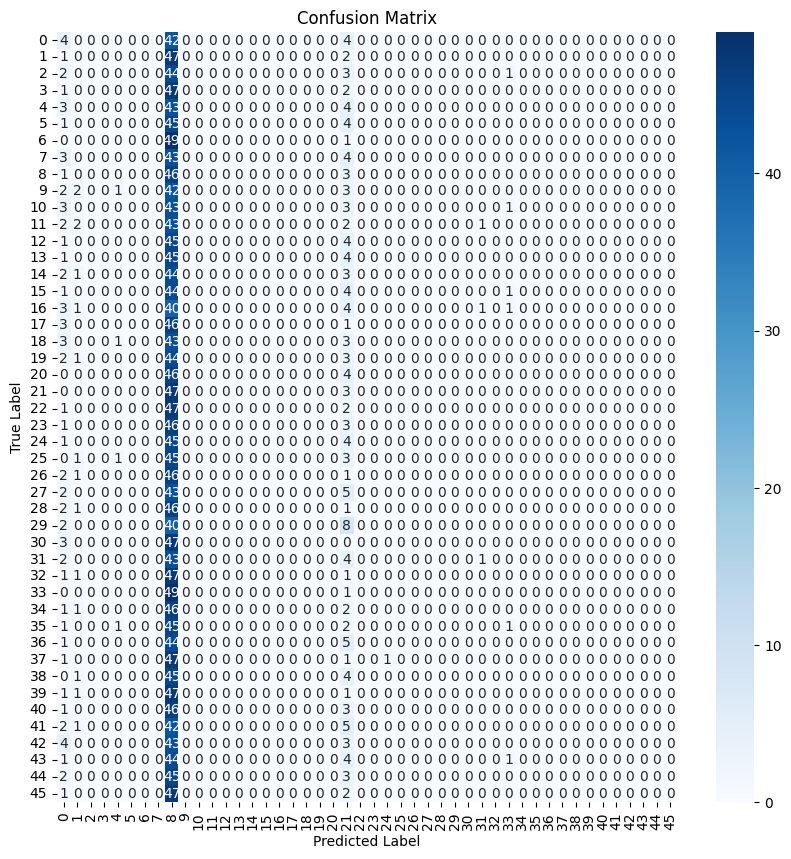

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix as a heat map
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues', ax=ax)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Question 2

<h3> References : <br>
https://github.com/elena-ecn/optuna-optimization-for-PyTorch-CNN

In [1]:
pip install optuna 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.4 MB/s eta 0:00:00


In [3]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import optuna
from optuna.trial import TrialState


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
class Net(nn.Module):

    def __init__(self, trial, num_conv_layers, num_filters, num_neurons=256, drop_conv2=0.3, drop_fc1=0.3):

        super().__init__()
        # Initialize parent class

        in_size = 28
        kernel_size = 3

        # Define the convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(1, num_filters[0], kernel_size=(3, 3), padding=1),
            *[nn.Sequential(
                nn.Conv2d(num_filters[i - 1], num_filters[i], kernel_size=(3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)) if i % 2 == 1 else nn.Sequential(
                nn.Conv2d(num_filters[i - 1], num_filters[i], kernel_size=(3, 3), padding=1),
                nn.ReLU())
              for i in range(1, num_conv_layers)
            ]
        )

        out_size = (in_size - kernel_size + 2) + 1  # Size of the output kernel
        out_size = out_size // 2  # Size after pooling

        self.conv2_drop = nn.Dropout2d(p=drop_conv2)  # Dropout for conv2
        self.out_feature = num_filters[-1] * out_size * out_size  # Size of flattened features
        self.fc1 = nn.Linear(self.out_feature, num_neurons)  # Fully Connected layer 1
        self.fc2 = nn.Linear(num_neurons, 10)  # Fully Connected layer 2
        self.p1 = drop_fc1  # Dropout ratio for FC1

        # Initialize weights with the He initialization
        for conv in self.convs:
            if isinstance(conv, nn.Conv2d):
                nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')
                if conv.bias is not None:
                    nn.init.constant_(conv.bias, 0)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')

    def forward(self, x):
        """Forward propagation.

        Parameters:
            - x (torch.Tensor): Input tensor of size [N,1,28,28]
        Returns:
            - (torch.Tensor): The output tensor after forward propagation [N,10]
        """

        x = self.convs(x)  # Convolution layers

        x = self.conv2_drop(x[2])  # Dropout for Conv2
        x = F.relu(F.max_pool2d(x, 2))  # Max pooling after Conv2
        x = x.view(-1, self.out_feature)  # Flatten tensor
        x = F.relu(self.fc1(x))  # Fully Connected layer 1
        x = F.dropout(x, p=self.p1, training=self.training)  # Dropout after FC1
        x = self.fc2(x)  # Fully Connected layer 2

        return F.log_softmax(x, dim=1)  # log(softmax(x))


In [ ]:
def train(network, optimizer, train_loader, device, max_batches):

    network.train()  # Set the module in training mode (only affects certain modules)

    total_loss = 0.0
    num_batches = 0

    for data, target in train_loader:  # For each batch
        if num_batches >= max_batches:
            break

        data, target = data.to(device), target.to(device)  # Move data to device

        optimizer.zero_grad()  # Clear gradients

        output = network(data)  # Forward propagation
        loss = F.nll_loss(output, target)  # Compute loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss
                                  # Update weights

def test(network):
    
    network.eval()  # Set the module in evaluation mode (only affects certain modules)
    correct = 0
    num_batches = min(len(test_loader), (number_of_test_examples + batch_size_test - 1) // batch_size_test)
    for batch_i in range(num_batches):
        start_idx = batch_i * batch_size_test
        end_idx = min(start_idx + batch_size_test, number_of_test_examples)
        data, target = test_loader[start_idx:end_idx]
        with torch.no_grad():  # Disable gradient calculation (when you are sure that you will not call Tensor.backward())
            output = network(data.to(device))  # Forward propagation
            pred = output.argmax(dim=1, keepdim=True)  # Find max value in each row, return indexes of max values
            correct += pred.eq(target.to(device)).sum().item()  # Compute correct predictions
    accuracy_test = correct / number_of_test_examples
    return accuracy_test




In [ ]:
def objective(trial, number_of_train_samples):
    # Define range of values to be tested for the hyperparameters
    num_conv_layers = trial.suggest_int("num_conv_layers", 3, 6)  # Number of convolutional layers

    num_filters = []
    for i in range(num_conv_layers):
        num_filters_i = trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16)
        num_filters.append(int(num_filters_i))

    model = Net(trial, num_conv_layers, num_filters).to(device)

    n_epochs = trial.suggest_int("n_epochs", 10, 50, 10)
    lr = trial.suggest_loguniform("lr", 0.0001, 0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        train(model, optimizer, train_loader, device, number_of_train_samples)
        accuracy = test(model)
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


In [ ]:
import torch
import os

def initialize():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size_train = 64
    batch_size_test = 64
    number_of_trials = 100
    limit_obs = False
    
    if limit_obs:
        number_of_train_examples = 256 * batch_size_train
        number_of_test_examples = 64 * batch_size_test
    else:
        number_of_train_examples = 60000
        number_of_test_examples = 10000
    
    # Make runs repeatable
    random_seed = 42
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)

    directory_name = 'files'
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)

    return device, batch_size_train, batch_size_test, number_of_trials, limit_obs, number_of_train_examples, number_of_test_examples, random_seed, directory_name


In [ ]:
device, batch_size_train, batch_size_test, number_of_trials, limit_obs, number_of_train_examples, number_of_test_examples, random_seed, directory_name = initialize()

In [ ]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)

# Create an Optuna study to maximize test accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=number_of_trials)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

trial = study.best_trial
print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Save results to csv file
df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
df = df.loc[df['state'] == 'COMPLETE']        # Keep only results that did not prune
df = df.drop('state', axis=1)                 # Exclude state column
df = df.sort_values('value')                  # Sort based on accuracy
df.to_csv('optuna_results.csv', index=False)  # Save to csv file

# Display results in a dataframe
print("\nOverall Results (ordered by accuracy):\n {}".format(df))

# Find the most important hyperparameters
most_important_parameters = optuna.importance.get_param_importances(study, target=None)

# Display the most important hyperparameters
print('\nMost important hyperparameters:')
for key, value in most_important_parameters.items():
    print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))

[I 2023-04-26 14:22:08,690] A new study created in memory with name: no-name-e6d66408-f9f7-4e04-bf62-afc3e1f03b38
/tmp/ipykernel_8500/2728841743.py:151: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
[I 2023-04-26 14:33:28,548] Trial 0 finished with value: 0.924299955368042 and parameters: {'num_conv_layers': 5, 'num_filter_0': 16.0, 'num_filter_1': 32.0, 'num_filter_2': 96.0, 'num_filter_3': 32.0, 'num_filter_4': 112.0, 'n_epochs': 30, 'lr': 0.0009838455970613026}. Best is trial 0 with value: 0.924299955368042.
[I 2023-04-26 14:36:31,781] Trial 1 finished with value: 0.9264999628067017 and parameters: {'num_conv_layers': 3, 'num_filter_0': 16.0, 'num_filter_1': 96.0, 'num_filter_2': 112.0, 'n_epochs': 10, 'lr': 0.00017870356


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  78
  Number of complete trials:  22
Best trial:
  Value:  0.9384999871253967
  Params: 
    num_conv_layers: 3
    num_filter_0: 64.0
    num_filter_1: 112.0
    num_filter_2: 128.0
    n_epochs: 30
    lr: 0.0004589245878674681

Overall Results (ordered by accuracy):
     number   value  params_lr  params_n_epochs  params_num_conv_layers   
3        3  0.1000   0.084493               20                       4  \
4        4  0.1000   0.026826               10                       5   
2        2  0.8749   0.005476               10                       5   
0        0  0.9243   0.000984               30                       5   
1        1  0.9265   0.000179               10                       3   
10      10  0.9333   0.000107               40                       3   
26      26  0.9336   0.000424               30                       3   
89      89  0.9337   0.000495               30          